In [1]:
import bw2data, bw2io
import bw2calc
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

### 1. create a new empty ds with the correct dimension, 

##### have to use one data varaible to store dpCFs value, then create multiple dimention for the LCIA indicator (dpIRF/dpCRF/dpGWP), don't know how to assign multile data variable 

In [2]:
# Define dimensions
gases = ["CO2", "CH4", "N2O"]
ssps = ["119","245","585"]  #"126"
mys = [2020,2030,2040,2050]
yrs = np.arange(101) #cf_xr["Year"].values
ensems = np.arange(1001) 
dpLCIA_IC = ["dpIRF", "dpCRF", "dpGWP"]

# Create a new xarray dataset with dimensions
ds = xr.Dataset(coords={'GHG': gases, 'SSP': ssps, 'dpLCIA': dpLCIA_IC,  'ModelYear': mys, 'Year': yrs, 'ensemble': ensems})

# Example data array
cf_random = xr.DataArray(np.random.rand(len(gases), len(ssps), len(dpLCIA_IC), len(mys), len(yrs), len(ensems)),
                          dims=('GHG', 'SSP', 'dpLCIA', 'ModelYear', 'Year', 'ensemble'),
                          coords={'GHG': gases, 'SSP': ssps, 'dpLCIA': dpLCIA_IC, 'ModelYear': mys, 'Year': yrs, 'ensemble': ensems})

 
# Assign the data variable to the dataset
ds = ds.assign(dpCF =  cf_random )

print(ds.dims)
ds

Frozen({'GHG': 3, 'SSP': 3, 'dpLCIA': 3, 'ModelYear': 4, 'Year': 101, 'ensemble': 1001})


<xarray.Dataset>
Dimensions:    (GHG: 3, SSP: 3, dpLCIA: 3, ModelYear: 4, Year: 101,
                ensemble: 1001)
Coordinates:
  * GHG        (GHG) <U3 'CO2' 'CH4' 'N2O'
  * SSP        (SSP) <U3 '119' '245' '585'
  * dpLCIA     (dpLCIA) <U5 'dpIRF' 'dpCRF' 'dpGWP'
  * ModelYear  (ModelYear) int64 2020 2030 2040 2050
  * Year       (Year) int64 0 1 2 3 4 5 6 7 8 9 ... 92 93 94 95 96 97 98 99 100
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
Data variables:
    dpCF       (GHG, SSP, dpLCIA, ModelYear, Year, ensemble) float64 0.1028 ....

### 2. assign the data variable to the ds for each gas / SSP / Year

In [3]:
for ghggas in ds['GHG'].values:   
    for sp in ds['SSP'].values: 
        for MY in ds['ModelYear'].values: 
            """ read_corresponding_excel_file for SSPx, ModelYear """
            filename = "agwp_dcf_gwp100_tstep1" + ghggas + "_ssp" + sp + "_fair_start2000MY" + str(MY) + ".xlsx"
            #print(filename)
            cf_file = os.path.join("/Users/susierwu/Dropbox/DLCA_DynCO2/pdpLCA_GT/FaIR_dpCFs/output/metrics/", filename)
            
            for lcia in ds["dpLCIA"].values: 
                if lcia == "dpIRF": 
                    cf_df = pd.read_excel(cf_file, sheet_name = "rf_wh_ensmb_" + ghggas + str(MY) ) 
                elif lcia == "dpCRF": 
                    cf_df = pd.read_excel(cf_file, sheet_name = "agwp_wh_ensmb_" + ghggas + str(MY) ) 
                elif lcia == "dpGWP":
                    cf_df = pd.read_excel(cf_file, sheet_name = "gwp_wh_ensmb_" + ghggas + str(MY) ) 

                #start from the 1st column, stores the 1001 ensemble, #print(len(cf_irf_df.iloc[ : , 1:]))
                pd_cf = cf_df.iloc[ : , 1:].values  
                
                ds['dpCF'].loc[{'GHG':ghggas, 'SSP': sp, 'dpLCIA': lcia,  'ModelYear': MY}] = pd_cf 

In [4]:
len(ds.Year)

101

In [4]:
ds

<xarray.Dataset>
Dimensions:    (GHG: 3, SSP: 3, dpLCIA: 3, ModelYear: 4, Year: 101,
                ensemble: 1001)
Coordinates:
  * GHG        (GHG) <U3 'CO2' 'CH4' 'N2O'
  * SSP        (SSP) <U3 '119' '245' '585'
  * dpLCIA     (dpLCIA) <U5 'dpIRF' 'dpCRF' 'dpGWP'
  * ModelYear  (ModelYear) int64 2020 2030 2040 2050
  * Year       (Year) int64 0 1 2 3 4 5 6 7 8 9 ... 92 93 94 95 96 97 98 99 100
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
Data variables:
    dpCF       (GHG, SSP, dpLCIA, ModelYear, Year, ensemble) float64 2.042e-1...

#### explore the added 1001 uncertainty IRF, plot

(array([  2.,  15.,  54., 137., 246., 270., 170.,  79.,  22.,   6.]),
 array([1.48016185e-15, 1.57294626e-15, 1.66573066e-15, 1.75851507e-15,
        1.85129948e-15, 1.94408388e-15, 2.03686829e-15, 2.12965269e-15,
        2.22243710e-15, 2.31522151e-15, 2.40800591e-15]),
 <BarContainer object of 10 artists>)

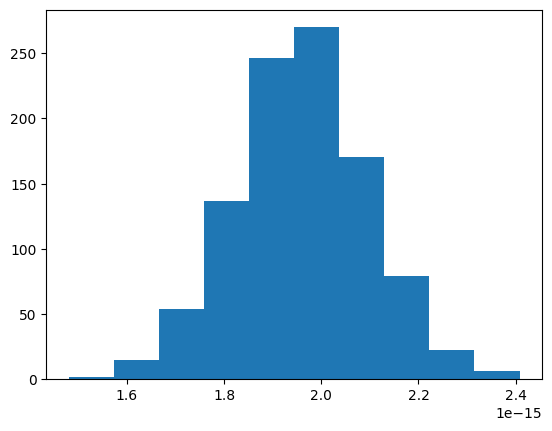

In [5]:
irf = ds.sel(Year = 0, SSP = "119", dpLCIA = "dpIRF", ModelYear = 2030, GHG = "CO2")["dpCF"].values
plt.hist(irf)

(array([  3.,  12.,  69., 168., 281., 263., 147.,  51.,   6.,   1.]),
 array([1.73741327e-12, 1.90382233e-12, 2.07023138e-12, 2.23664044e-12,
        2.40304950e-12, 2.56945856e-12, 2.73586761e-12, 2.90227667e-12,
        3.06868573e-12, 3.23509478e-12, 3.40150384e-12]),
 <BarContainer object of 10 artists>)

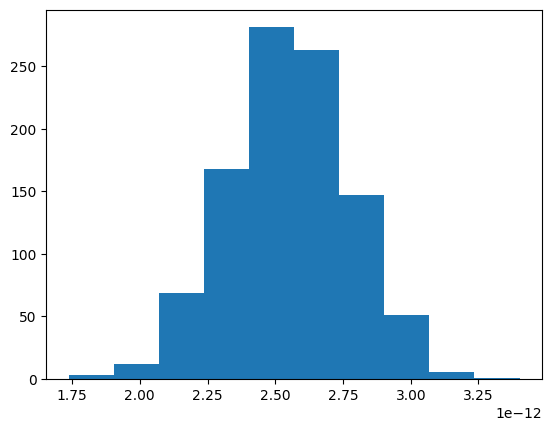

In [6]:
irf = ds.sel(Year = 100, SSP = "119", dpLCIA = "dpCRF", ModelYear = 2030, GHG = "CH4")["dpCF"].values
plt.hist(irf)

(array([  9.,  47., 165., 261., 272., 146.,  70.,  22.,   6.,   3.]),
 array([113.94370674, 132.39801575, 150.85232477, 169.30663378,
        187.76094279, 206.2152518 , 224.66956081, 243.12386982,
        261.57817883, 280.03248784, 298.48679685]),
 <BarContainer object of 10 artists>)

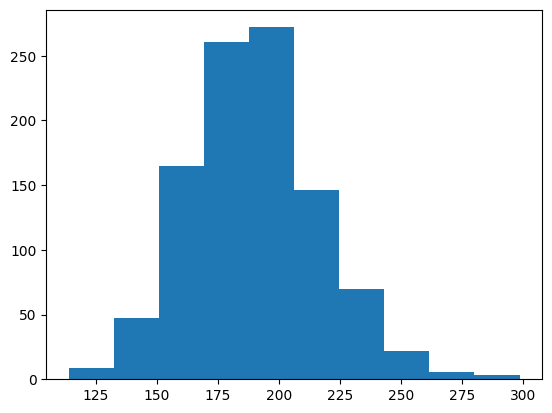

In [7]:
plt.hist(ds.sel( SSP = "119", Year = 100, dpLCIA = "dpGWP", GHG = "N2O", ModelYear = 2020)['dpCF'].values)

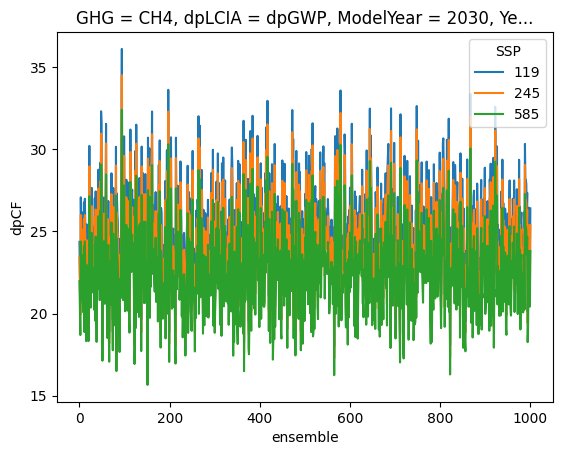

In [8]:
ds.sel( Year = 100,GHG = "CH4", dpLCIA = "dpGWP", ModelYear = 2030)['dpCF'].plot(hue = "SSP");

(array([ 14.,  65., 171., 245., 266., 121.,  76.,  34.,   8.,   1.]),
 array([15.34549254, 17.01112917, 18.6767658 , 20.34240244, 22.00803907,
        23.6736757 , 25.33931233, 27.00494896, 28.6705856 , 30.33622223,
        32.00185886]),
 <BarContainer object of 10 artists>)

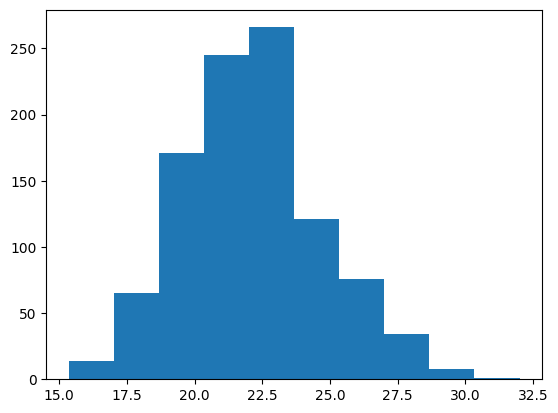

In [9]:
plt.hist(ds.sel( SSP = "119", Year = 100, dpLCIA = "dpGWP", GHG = "CH4", ModelYear = 2020)['dpCF'].values)

### 3.  save to .nc for dpCFs with uncertainty

In [10]:
ds.to_netcdf('CF_perSSP_MY_majorghgs_wh1001ensemb.nc')